In [32]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error , make_scorer 
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import scipy.stats as stats
import joblib
import matplotlib.pyplot as plt


In [3]:
train_df = pd.read_csv('train.csv', parse_dates=['date'])

train_df = train_df.sort_values('date')

In [4]:
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
211816,2013-01-01,7,12,26
832656,2013-01-01,7,46,27
213642,2013-01-01,8,12,54
215468,2013-01-01,9,12,35


In [5]:
train_df.describe()

,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 12:00:00.000000256,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 34.8 MB


In [7]:
train_df.groupby('store').nunique()['item'].sort_values(ascending=False)

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [8]:
train_df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
               sum       mean median        std
store item                                     
1     1      36468  19.971522   19.0   6.741022
      2      97050  53.148959   52.0  15.005779
      3      60638  33.208105   33.0  10.072529
      4      36440  19.956188   20.0   6.640618
      5      30335  16.612815   16.0   5.672102
...            ...        ...    ...        ...
10    46    120601  66.046550   65.0  18.114991
      47     45204  24.755750   24.0   7.924820
      48    105570  57.814896   57.0  15.898538
      49     60317  33.032311   32.0  10.091610
      50    135192  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [9]:
train_df

,date,store,item,sales
0,2013-01-01,1,1,13
211816,2013-01-01,7,12,26
832656,2013-01-01,7,46,27
213642,2013-01-01,8,12,54
215468,2013-01-01,9,12,35
...,...,...,...,...
619013,2017-12-31,9,34,21
620839,2017-12-31,10,34,32
622665,2017-12-31,1,35,55
598927,2017-12-31,8,33,100


In [ ]:
def create_features(dataframe):
    df_feat = dataframe.copy()
    df_feat['year'] = df_feat['date'].dt.year
    df_feat['month'] = df_feat['date'].dt.month
    df_feat['day'] = df_feat['date'].dt.day
    df_feat['dayofweek'] = df_feat['date'].dt.dayofweek 
    df_feat['dayofyear'] = df_feat['date'].dt.dayofyear
    df_feat['weekofyear'] = df_feat['date'].dt.isocalendar().week.astype(int)
    df_feat['quarter'] = df_feat['date'].dt.quarter
    df_feat['is_weekend'] = (df_feat['dayofweek'] >= 5).astype(int)

    print("  - Date features created.")

    df_feat = df_feat.sort_values(['store', 'item', 'date'])

    lags = [7, 14, 21, 28, 35, 60, 91, 182, 364] 
    for lag in lags:
        df_feat[f'sales_lag_{lag}'] = df_feat.groupby(['store', 'item'])['sales'].shift(lag)
    print(f"  - Lag features created for lags: {lags}")

    shift_base = 7
    windows = [7, 14, 28, 60, 90]
    for window in windows:
        df_feat[f'sales_roll_mean_{shift_base}_{window}'] = df_feat.groupby(['store', 'item'])['sales'].shift(shift_base).transform(
            lambda x: x.rolling(window, min_periods=window // 4).mean()
        )
        df_feat[f'sales_roll_std_{shift_base}_{window}'] = df_feat.groupby(['store', 'item'])['sales'].shift(shift_base).transform(
            lambda x: x.rolling(window, min_periods=window // 4).std()
        )
    print(f"  - Rolling window features created for windows: {windows} (based on lag {shift_base})")

    df_feat = df_feat.sort_values('date')

    print("Feature engineering complete.")
    return df_feat

In [12]:
df_processed = create_features(train_df)

  - Date features created.
  - Lag features created for lags: [7, 14, 21, 28, 35, 60, 91, 182, 364]
  - Rolling window features created for windows: [7, 14, 28, 60, 90] (based on lag 7)
Feature engineering complete.


In [13]:
df_processed.head()

,date,store,item,sales,year,month,day,dayofweek,dayofyear,weekofyear,...,sales_roll_mean_7_7,sales_roll_std_7_7,sales_roll_mean_7_14,sales_roll_std_7_14,sales_roll_mean_7_28,sales_roll_std_7_28,sales_roll_mean_7_60,sales_roll_std_7_60,sales_roll_mean_7_90,sales_roll_std_7_90
0,2013-01-01,1,1,13,2013,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295812,2013-01-01,3,17,26,2013,1,1,1,1,1,...,23.333333,5.006662,24.307692,5.721081,24.777778,6.103803,29.745763,7.689207,31.112360,7.746610
125994,2013-01-01,10,7,32,2013,1,1,1,1,1,...,57.666667,9.852242,59.846154,9.685437,62.444444,10.881648,68.593220,13.227608,69.842697,12.720687
314072,2013-01-01,3,18,45,2013,1,1,1,1,1,...,33.000000,9.549869,31.076923,7.410146,32.962963,8.211069,40.000000,10.097798,40.550562,9.089218
332332,2013-01-01,3,19,34,2013,1,1,1,1,1,...,80.166667,13.151679,78.615385,14.315135,83.407407,17.011895,100.288136,23.471223,102.483146,21.502173


In [14]:
max_lag = 364 
initial_rows = len(df_processed)
df_processed = df_processed.dropna()
print(f"Rows after dropping NaN values: {len(df_processed)} (removed {initial_rows - len(df_processed)} rows)")

Rows after dropping NaN values: 731000 (removed 182000 rows)


In [15]:
df_processed['store'] = df_processed['store'].astype('category')
df_processed['item'] = df_processed['item'].astype('category')
df_processed['dayofweek'] = df_processed['dayofweek'].astype('category')
df_processed['month'] = df_processed['month'].astype('category')

In [16]:
TRAIN_END_DATE = '2016-12-31'
TEST_START_DATE = '2017-01-01'
TEST_END_DATE = '2017-12-31'

In [17]:
# Ensure data exists before splitting
train_mask = df_processed[df_processed['date'] <= TRAIN_END_DATE]
test_mask = df_processed[df_processed['date'] >= TEST_START_DATE]

X_train = train_mask.drop(columns=["date","sales"])
y_train = train_mask['sales']

X_test = test_mask.drop(columns=["date","sales"])
y_test = test_mask["sales"]

In [18]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (548500, 29), y_train shape: (548500,)
X_test shape: (182500, 29), y_test shape: (182500,)


In [ ]:
param_dist = {
    'n_estimators': stats.randint(800, 2500), 
    'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.07], 
    'num_leaves': stats.randint(20, 50),      
    'max_depth': [-1, 5, 7, 10, 15],          
    'feature_fraction': [0.7, 0.8, 0.9, 1.0],
    'bagging_fraction': [0.7, 0.8, 0.9, 1.0],
    'bagging_freq': [0, 1, 2, 5],           
    'reg_alpha': stats.uniform(0, 1),         
    'reg_lambda': stats.uniform(0, 1),        
    'min_child_samples': stats.randint(10, 50) 
}

In [55]:
base_model = lgb.LGBMRegressor(
    objective='regression_l1',
    metric='mae',
    n_jobs=-1,
    seed=42,
    boosting_type='gbdt',
    verbose = -1,
    num_threads = -1
)

In [56]:
n_cv_splits = 5
tscv = TimeSeriesSplit(n_splits=n_cv_splits)

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [ ]:
n_random_iter = 50 

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=n_random_iter,
    scoring=mae_scorer,
    cv=tscv, 
    n_jobs=-1, 
    verbose=2, 
    random_state=42
)

In [58]:
categorical_features_names = [col for col in X_train.columns if X_train[col].dtype == 'category']
print(f"Categorical features identified for LGBM: {categorical_features_names}")

Categorical features identified for LGBM: ['store', 'item', 'month', 'dayofweek']


In [59]:
random_search.fit(X_train, y_train, categorical_feature=categorical_features_names)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LGBMRegressor(metric='mae', n_jobs=-1,
                                           num_threads=-1,
                                           objective='regression_l1', seed=42,
                                           verbose=-1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bagging_fraction': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'bagging_freq': [0, 1, 2, 5],
                                        'feature_fraction': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_r...
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002D685B5DC40>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002D685B1DDF0>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002D685B3D640>},
                   random_state=42,
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                   verbose=2)

In [60]:
print("Best Parameters found:")
print(random_search.best_params_)
print(f"Best MAE score on CV (Negative MAE): {random_search.best_score_:.4f}")
print(f"Equivalent Positive MAE on CV: {-random_search.best_score_:.4f}")

Best Parameters found:
{'bagging_fraction': 1.0, 'bagging_freq': 2, 'feature_fraction': 0.9, 'learning_rate': 0.01, 'max_depth': -1, 'min_child_samples': 44, 'n_estimators': 2482, 'num_leaves': 35, 'reg_alpha': 0.8466611422383059, 'reg_lambda': 0.8563242918780924}
Best MAE score on CV (Negative MAE): -6.2478
Equivalent Positive MAE on CV: 6.2478


In [61]:
best_params = random_search.best_params_
final_model = lgb.LGBMRegressor(objective='regression_l1', metric='mae', n_jobs=-1, seed=42, boosting_type='gbdt', verbose=-1, num_threads=-1, **best_params)

In [62]:
final_model.fit(X_train, y_train, categorical_feature=categorical_features_names)

LGBMRegressor(bagging_fraction=1.0, bagging_freq=2, feature_fraction=0.9,
              learning_rate=0.01, metric='mae', min_child_samples=44,
              n_estimators=2482, n_jobs=-1, num_leaves=35, num_threads=-1,
              objective='regression_l1', reg_alpha=0.8466611422383059,
              reg_lambda=0.8563242918780924, seed=42, verbose=-1)

In [ ]:
print('Saving model using joblib...')
model_filename_joblib = 'lgbm_model.joblib'
joblib.dump(final_model, model_filename_joblib) 
print(f'Model saved to {model_filename_joblib}')

In [20]:
model_filename_joblib = 'lgbm_model.joblib'
bestmodel = joblib.load(model_filename_joblib)

In [ ]:
prediction = bestmodel.predict(X_test)
prediction[prediction < 0] = 0


In [ ]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    epsilon = 1e-9 
    
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0 + epsilon 
    
    return np.mean(numerator / denominator) * 100.0

In [ ]:
final_rmse = np.sqrt(mean_squared_error(y_test, prediction))
final_mae = mean_absolute_error(y_test, prediction)
epsilon = 1e-9
final_mape = mean_absolute_percentage_error(y_test + epsilon, prediction + epsilon) * 100
final_smape = smape(y_test, prediction) 

print(f"Final Model Evaluation Metrics on Test Set:")
print(f"  RMSE: {final_rmse:.4f}")
print(f"  MAE:  {final_mae:.4f}") 
print(f"  MAPE: {final_mape:.2f}%")
print(f"  SMAPE: {final_smape:.2f}%") 


Final Model Evaluation Metrics on Test Set:
  RMSE: 7.9503
  MAE:  6.1107
  MAPE: 12.53%
  SMAPE: 12.07%



Plotting feature importance...


<Figure size 1000x800 with 0 Axes>

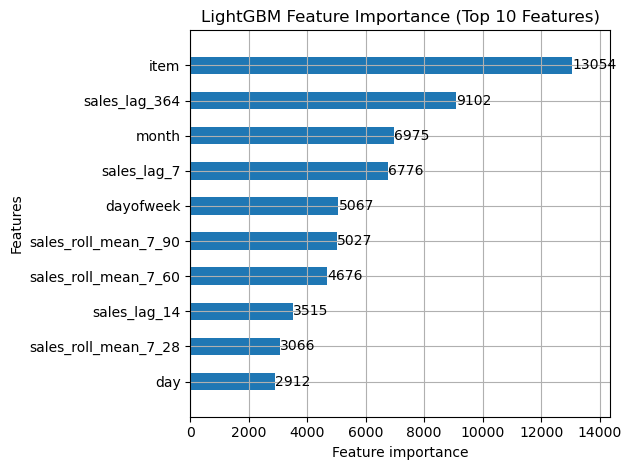

In [39]:
print("\nPlotting feature importance...")
    
plt.figure(figsize=(10, 8)) 

lgb.plot_importance(
    bestmodel, 
    max_num_features=10, 
    height=0.5,          
    importance_type='split' 
)

plt.title("LightGBM Feature Importance (Top 10 Features)") 
plt.tight_layout()
plt.show()